In [ ]:
load("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/Nissle_processed.RData")
library(tidyverse)
library(reshape2)
library(magrittr)
library(lemon)
library(BSgenome)
library(MutationalPatterns)
library(plyr)
library(data.table)
library(vroom)
library(ggpubr)
library(cowplot)
library(patchwork)
library(BSgenome.Hsapiens.UCSC.hg38)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(sjPlot)

ref_genome = "BSgenome.Hsapiens.UCSC.hg38"
genes = genes(TxDb.Hsapiens.UCSC.hg38.knownGene)

In [ ]:
get_context = function(gr, size_context = 10){
  gr = gr[gr$FILTER == "PASS"]
  gr = gr[which(nchar(gr$REF) == 1 )]
  strand = ifelse(gr$REF == "G" | gr$REF == "A", '-', "+")
  start = start(gr)
  ref = as.character(gr$REF)
  alt = unlist(CharacterList(gr$ALT))
  type = paste0(ref, ">", alt)
  chromosome = as.character(seqnames(gr))
  context = getSeq(Hsapiens, chromosome,  start = start - size_context,
                   end =  start + size_context,
                   strand = strand)

  type = mapvalues(type, c("A>C","A>G","A>T","G>C", "G>A","G>T"),
                   c("T>G", "T>C", "T>A", "C>G", "C>T", "C>A"), warn_missing	= FALSE)
  trinucleotide = paste0(substr(context, 10, 10), "[", type, "]", substr(context, 12,12))


  context_table = tibble(chr = chromosome, position = start, type = type, strand = strand,
                         context = as.character(context), trinucleotide = trinucleotide)
  context_table$id = paste0(context_table$chr, "_", context_table$position, "_", context_table$type)
  return(context_table)
}

In [ ]:
plot_indel_contexts2 = function (counts, same_y = FALSE, extra_labels = FALSE, condensed = FALSE)
{


  INDEL_COLORS <- c(
    "#FDBE6F", "#FF8001", "#B0DD8B", "#36A12E", "#FDCAB5", "#FC8A6A",
    "#F14432", "#BC141A", "#D0E1F2", "#94C4DF", "#4A98C9", "#1764AB",
    "#E2E2EF", "#B6B6D8", "#8683BD", "#61409B"
  )


  count <- muttype <- muttype_sub <- muttype_total <- sample <- NULL
  counts <- counts %>% as.data.frame() %>% tibble::rownames_to_column("muttype_total") %>%
    tidyr::separate(muttype_total, c("muttype", "muttype_sub"),
                    sep = "_(?=[0-9])") %>% dplyr::mutate(muttype = factor(muttype,
                                                                           levels = unique(muttype))) %>% tidyr::gather(key = "sample",
                                                                                                                        value = "count", -muttype, -muttype_sub) %>% dplyr::mutate(sample = factor(sample,
                                                                                                                                                                                                   levels = unique(sample)))
  nr_muts <- counts %>% dplyr::group_by(sample) %>% dplyr::summarise(nr_muts = round(sum(count)))
  facet_labs_y <- nr_muts$sample
  names(facet_labs_y) <- nr_muts$sample
  facet_labs_x <- c("1: C", "1: T", "1: C", "1: T", 2, 3, 4,
                    "5+", 2, 3, 4, "5+", 2, 3, 4, "5+")
  names(facet_labs_x) <- levels(counts$muttype)
  if (same_y) {
    facet_scale <- "free_x"
  }
  else {
    facet_scale <- "free"
  }
  if (extra_labels) {
    title <- stringr::str_c("Deletion           ", "Insertion          ",
                            "Deletion                                   ", "Insertion                                  ",
                            "Deletion (MH)")
    x_lab <- stringr::str_c("Homopolymer length                            ",
                            "Number of repeat units                                                                               ",
                            "Microhomology length")
  }
  else {
    title <- x_lab <- ""
  }
  if (condensed == TRUE) {
    width <- 1
    spacing <- 0
  }
  else {
    width <- 0.6
    spacing <- 0.5
  }
  fig <- ggplot(counts, aes(x = muttype_sub, y = count, fill = muttype,
                            width = width)) + geom_bar(stat = "identity") + facet_grid(sample ~
                                                                                         muttype, scales = facet_scale, space = "free_x", labeller = labeller(muttype = facet_labs_x,
                                                                                                                                                              sample = facet_labs_y)) + scale_fill_manual(values = INDEL_COLORS) +
    theme_bw() + labs(fill = "Mutation type", title = title,
                      y = "Nr of indels", x = x_lab) + theme(panel.grid.major.x = element_blank(),
                                                             panel.grid.minor.y = element_blank(), panel.spacing.x = unit(spacing,
                                                                                                                          "lines"))
  return(fig)
}

In [ ]:
gb_map <- list(
  GB19 = list(crypt = c("C22_19_SI", "D4_19_TR"), blood = "GIB-019"),
  GB9  = list(crypt = c("A9_09_CE", "B29_09_AS", "D2_09_TR"), blood = "GIB-09"),
  GB130 = list(crypt = c("24_130DC","30_130RE","33_130AS","B35_130_TR","D17_130_CE"), blood = "GIB-130"),
  GB180 = list(crypt = c("23_180RE","A15__180_TR","A10__180_DC","B38_180_SI","B12_180_AS","C16_180_CE"), blood = "GIB-180"),
  GB93 = list(crypt = c("A8__093_SI","B22_93_TR","B32_93_AS","C17_93_AS","C10_93_CE","D24_093_RE"), blood = "GIB-93"),
  GB74 = list(crypt = c("74_DC","29_74TR","A5__074_AS","D14_074_RE","D27_074_SI"), blood = "GIB-74"),
  GB76 = list(crypt = c("D32_076_CE","22_76TR","B4_076_SI","D13_076_RE","D8_076_AS","D33_076_DE"), blood = "GIB-76"),
  GB31 = list(crypt = c("031_RE_T","A1__031_AS","B14_031_CE","B5_031_RE","B28_31_TR","C24_31_TR","D31_031_DE"), blood = "GIB-031"),
  GB30 = list(crypt = c("030_CE_T","30_TR","B7_030_DC","D10_030_RE","D29_030_AS"), blood = "GIB-030"),
  GB58 = list(crypt = c("058_RE_T","58_TR","58_DC","B10_058_CE","D12_058_SI"), blood = "GIB-58"),
  GB84 = list(crypt = c("A16__084_CE","B3_084_DC","D6_84_RE","D26_084_SI","D9_084_AS","12b_D12_84_TR"), blood = "GIB-84"),
  GB27 = list(crypt = c("27_CE","27_DC","19_27TR","17_27AS","18_27RE"), blood = "GIB-027"),
  GB29 = list(crypt = c("29_CE","029_DC_T","32_29TR","D25_029_RE","D30_029_AS"), blood = "GIB-029"),
  GB103 = list(crypt = c("103_RE","A6__103_CE","B8_103_SI","C1_103_TR","C3_103_DE"), blood = "GIB-103"),
  GB116 = list(crypt = c("B27_116_AS","116_TR","116_RE_T","21_116CE","A7__116_DC","B2_116_RE"), blood = "GIB-116"),
  GB148 = list(crypt = c("148_SI","A2__148_CE","A13__148_AS","B13_148_DC","B15_148_RE","C5_148_TR"), blood = "GIB-148"),
  GB40 = list(crypt = c("40_AS","20_40DC","D7_40_RE","D16_040_SI"), blood = "GIB-040"),
  GB115 = list(crypt = c("Laurel-2","Laurel-10","B1_115_SI","B9_115_RE","B26_115_DC","B18_115_TC","C14_115_TR",
                         "Laurel-1","Laurel-3","Laurel-5","Laurel-6","Laurel-7","Laurel-8","Laurel-11","Laurel-12"),
                blood = "GIB-115"),
  GB273 = list(crypt = c("B43_273_AS","B44_273_TR","B45_273_SI","B46_273_DE","B47_273_RE","B20_273_CE"), blood = NA_character_),
  GB153 = list(crypt = c("B21_153_CE","B33_153_AS","B6_153_SI","B23_153_RE","C6_153_RE","D11_153_DE","D18_153_TR","D20_153_SI"), blood = NA_character_),
  GB277 = list(crypt = c("B41_277_AC","B39_277_CE","B42_277_RTM","B17_277_DC","B19_277_TC","C15_277_TR","C18_277_DE","D15_277_SI","D15b_277_SI"), blood = "GIB-277")
)

# --- 2) cohorts (GB-level) as you provided ---
cohort_gbs <- list(
  normal = c("GB9","GB40","GB103","GB130","GB180","GB58","GB27","GB148","GB153","GB273","GB277"),
  adenoma = c("GB19","GB31","GB30","GB76","GB115","GB116","GB29","GB74","GB84","GB93")
)

# --- 3) expand cohorts to sample-level (collect crypt_samples for each cohort) ---
cohort_samples <- lapply(cohort_gbs, function(gbs) {
  unique(unlist(lapply(gbs, function(gb) {
    if (!is.null(gb_map[[gb]])) gb_map[[gb]]$crypt else character(0)
  })))
})



In [ ]:
vcf_files =  list.files("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs/input", recursive = T, full.names = T, pattern = "\\.vcf")
names(vcf_files) <- basename(vcf_files)
names(vcf_files) <- gsub("\\.nuclear_all\\.intersection\\.vcf$", "", names(vcf_files))

In [ ]:
vcf_indel_files = list.files("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/indels/input", full.names = T)
names(vcf_indel_files) <- basename(vcf_indel_files)
names(vcf_indel_files) <- gsub("\\.nuclear_all_indels\\.intersection\\.vcf$", "", names(vcf_indel_files))

In [ ]:
vcfs = read_vcfs_as_granges(vcf_files, names(vcf_files), genome =  ref_genome, type = "all")
vcfs_sbs = get_mut_type(vcfs, "snv")

In [ ]:
vcfs_indel = read_vcfs_as_granges(vcf_indel_files, names(vcf_indel_files), ref_genome, type = "indel")
vcfs_indel = get_mut_type(vcfs_indel, "indel")

In [ ]:
mut_mat = mut_matrix(vcfs_sbs, ref_genome)
mut_mat_s = mut_matrix_stranded(vcfs_sbs, ref_genome, genes)

In [ ]:
norm_variants <- function(x) {
  x <- trimws(as.character(x))
  unique(c(x, gsub("\\.", "_", x), gsub("_", ".", x)))
}

cat_names <- colnames(mut_mat)
categories_vec <- rep(NA_character_, length(cat_names))

for (cohort in names(cohort_samples)) {
  lookup <- unique(unlist(lapply(cohort_samples[[cohort]], norm_variants)))
  matches <- vapply(cat_names, function(nm) any(norm_variants(nm) %in% lookup), logical(1))
  categories_vec[matches] <- cohort
}
categories <- data.table(injection = categories_vec)
categories[, name := colnames(mut_mat)]
categories[, method := ifelse(grepl("NISL", name), "PTA", "Crypt")]

# make injection a factor with levels you want (only normal and adenoma)
categories$injection <- factor(categories$injection, levels = c("normal", "adenoma"))

# optional: warn about unmatched samples
if (any(is.na(categories$injection))) {
  warning(sprintf("There are %d samples unmatched to normal/adenoma. They will have NA in categories$injection.",
                  sum(is.na(categories$injection))))
}


In [ ]:
# get mutation loads
indel_loads = lengths(vcfs_indel) %>% as.data.frame()
colnames(indel_loads) = "total_indels"
id_contexts = MutationalPatterns::get_indel_context(vcfs_indel, ref_genome)
id_pks_contexts = lapply(id_contexts, select_context_indel, type = "Strelka")
indel_counts = count_indel_contexts(id_contexts)

indel_loads$in_pks_motif = lengths(id_pks_contexts)
indel_loads$fraction_pksmotif = indel_loads$in_pks_motif/lengths(id_contexts)

In [ ]:
indel_loads_save <- tibble::rownames_to_column(indel_loads, var = "name")
indel_loads_merged <- merge(indel_loads_save, categories, by.x = "name")

In [ ]:
write.csv(indel_loads_merged, file = paste0("2026_01_15_indel_loads.csv"), row.names = FALSE)

In [ ]:
# Load dinucleotide categories
nucs = c("A", "T", "C", "G")
dinucs = expand.grid(nucs, nucs)
dinucs = paste0(dinucs[,1],dinucs[,2])

####################################
# Extended mutational contexts
####################################
contexts = lapply(vcfs_sbs, get_context)


In [ ]:
# contexts has per sample specifics!! nice!!

In [ ]:
context_list = list(normal = contexts[categories$injection == "normal"],
                    adenoma = contexts[categories$injection == "adenoma"])

In [ ]:
for (name in names(context_list)) {
  ctx = context_list[[name]]
  ctx = rbindlist(ctx)
  ctx = dplyr::distinct(ctx)
  ctx = ctx[substr(ctx$type, 1,1) == "T","context"]
  write.table(ctx, file = paste0("Processed_data/Contexts/",name, "_unique_contexts.txt"), quote = F, col.names = F, row.names = F)
}

In [ ]:
contexts_TN = list()
for (type in names(context_list)) {
  ctx_table= context_list[[type]] %>%
    rbindlist() %>%
    distinct() %>%
    filter(grepl("^T", type))
  contexts_TN[[type]] = ctx_table
}

In [114]:
contexts_TN_sample <- context_list %>%
  purrr::flatten() %>%
  purrr::map(~ .x %>%
    distinct() %>%
    filter(grepl("^T", type))
  )

In [104]:
contexts_TN_sample <- setNames(
  contexts_TN_sample,
  names(contexts_TN_sample)
)

In [117]:
contexts_TN_sample <- context_list %>%
  purrr::flatten() %>%
  purrr::map(~ .x %>%
    distinct() %>%
    filter(grepl("^T", type))
  )

In [126]:
ext_context_sample %>%
    mutate(pos34 =  substr(context, 7,8)) %>%
    mutate(trinucleotide = factor(trinucleotide, levels = TRIPLETS_48)) %>%
    mutate(select =  ifelse(pos34 == "AA", "AA", "other") %>%
             factor(levels = c("other", "AA")))

name,chr,position,type,strand,context,trinucleotide,id,pos34,select
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>
058_RE_T,chr1,778483,T>C,+,ACATAAACACTGTGCTGGGTC,C[T>C]G,chr1_778483_T>C,AC,other
058_RE_T,chr1,20691550,T>C,+,AACTCCCAGGTTCAAGCGATT,G[T>C]T,chr1_20691550_T>C,CA,other
058_RE_T,chr1,30159550,T>C,-,TCTTGCCTTTTTAAAAAACTT,T[T>C]T,chr1_30159550_T>C,CT,other
058_RE_T,chr1,40250641,T>G,-,TTGAACTCTGTCATTGTCCAA,G[T>G]C,chr1_40250641_T>G,TC,other
058_RE_T,chr1,44320855,T>C,+,CTGAGTAAAATTAGCATGTGG,A[T>C]T,chr1_44320855_T>C,AA,AA
058_RE_T,chr1,53989983,T>C,+,TTTTGATTTCTAATCTCAAGA,C[T>C]A,chr1_53989983_T>C,TT,other
058_RE_T,chr1,72966684,T>C,+,CGTGGACTCCTGGATCTTTCT,C[T>C]G,chr1_72966684_T>C,CT,other
058_RE_T,chr1,76488590,T>A,+,TTAATACATATTTGTTGAATA,A[T>A]T,chr1_76488590_T>A,CA,other
058_RE_T,chr1,97117399,T>G,+,AAAGCAAAGCTTTTTTATTGC,C[T>G]T,chr1_97117399_T>G,AA,AA


In [ ]:
cat <- categories
cat$injection = factor(cat$injection, levels = c("normal", "adenoma"))
mut_counts = cat %>%
    mutate('SBS count' = colSums(mut_mat[, name]))

ktest = kruskal.test(`SBS count` ~ injection, data = mut_counts)
subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest$p.value, 3))

In [ ]:
F2a_sbs_boxplot = ggplot(mut_counts, aes(x = injection, y = `SBS count`, fill = injection)) +
    geom_boxplot(outlier.shape = NA, width = 0.4) +
    geom_jitter(shape = 21, width = 0.15) +
    geom_pwc(aes(group = injection), dodge = 0.2, method = "dunn_test",
             p.adjust.by = "panel", label = "{p.adj.format}", p.adjust.method = "fdr") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(mut_counts$`SBS count`)*1.45)) +
    theme_BM() +
    theme(plot.title = element_text(hjust = 0.5, size = 11), legend.position = "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(title = name, subtitle = subtitle, x = "")

mut_mat = mut_mat[,cat$name]

  # Plot 96-profiles
  # Make mutation matrices & plot mutation profiles for I3 and PTA-sequenced clones
  mm = t(mut_mat) %>% data.table(keep.rownames = "name")
  mm = merge(mm, mut_counts[,-4])
  mm_cat = mm %>% group_by(injection, method) %>%
    dplyr::select(-name) %>%
    summarize_all(sum) %>%
    dplyr::select(-method) %>%
    column_to_rownames("injection") %>%
    t()

  F2c_sbs_profile = plot_96_profile3(mm_cat) +
    theme(axis.text.x = element_text(size = 4.5))

Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


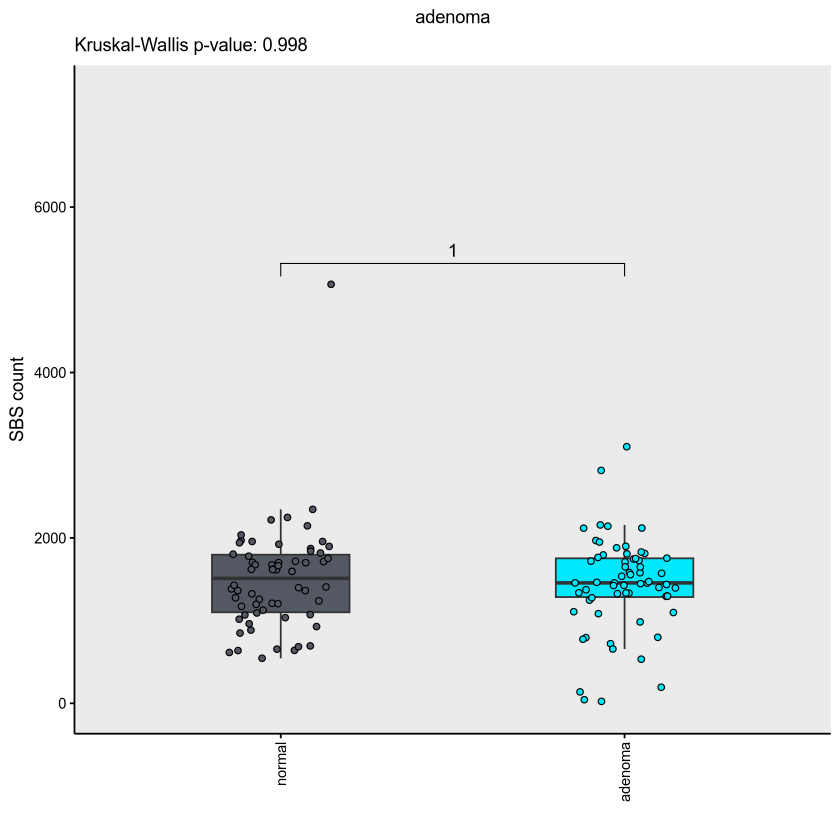

In [72]:
F2a_sbs_boxplot

Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


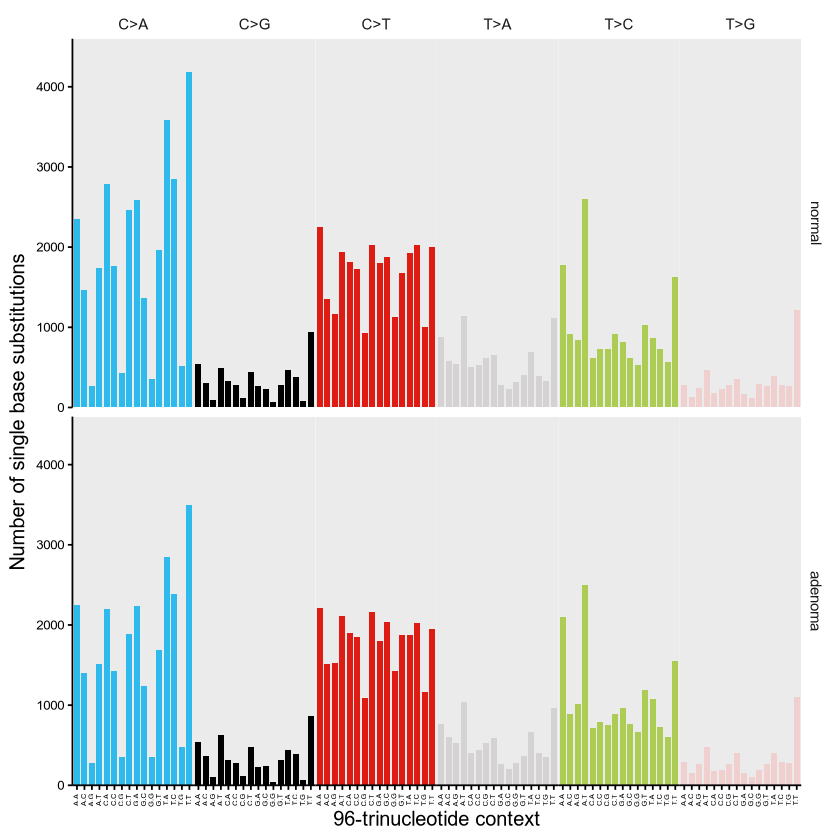

In [73]:
F2c_sbs_profile

In [ ]:
indel_mut_counts = mut_counts %>%
    mutate('indel count' = colSums(indel_counts[, name]))

indel_mut_counts = indel_mut_counts %>% arrange(method, injection)
  sjPlot::tab_df(indel_mut_counts, file = "Output/Supplementary_tables/Supplementary_Table_1.doc")

  #  Plot indel counts and mutational profiles
  indel_mut_counts_plot = indel_mut_counts

  ktest_indels = kruskal.test(`indel count` ~ injection, indel_mut_counts_plot)
  subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest_indels$p.value, 3))

In [ ]:
mm = t(mut_mat) %>% data.table(keep.rownames = "name")
  mm = merge(mm, mut_counts[,-4])
  mm_cat = mm %>% group_by(injection, method) %>%
    dplyr::select(-name) %>%
    summarize_all(sum) %>%
    dplyr::select(-method) %>%
    column_to_rownames("injection") %>%
    t()

  F2c_sbs_profile = plot_96_profile3(mm_cat) +
    theme(axis.text.x = element_text(size = 4.5))

In [ ]:
F2b_boxplot_indels = ggplot(indel_mut_counts_plot, aes(x = injection, y = `indel count`, fill = injection)) +
    geom_boxplot(outlier.shape = NA, width = 0.4) +
    geom_jitter(shape = 21, width = 0.15) +
    geom_pwc(aes(group = injection), method = "dunn_test",
             dodge = 0.2, p.adjust.by = "panel", label = "{p.adj.format}", p.adjust.method = "fdr") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(indel_mut_counts$`indel count`)*1.45)) +
    theme_BM() +
    theme(plot.title = element_text(hjust = 0.5, size = 11),
          legend.position = "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(title = "Indels", subtitle = subtitle, x = "")

  # Plot indel profiles
  indel_counts = indel_counts[, cat$name]
  id_mm = t(indel_counts) %>% data.table(keep.rownames = "name")
  id_mm = merge(id_mm, indel_mut_counts[,-4])
  id_mm = id_mm %>% group_by(injection, method) %>%
    dplyr::select(-name, -`indel count`) %>%
    summarize_all(sum) %>%
    dplyr::select(-method) %>%
    column_to_rownames("injection") %>%
    t()

Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


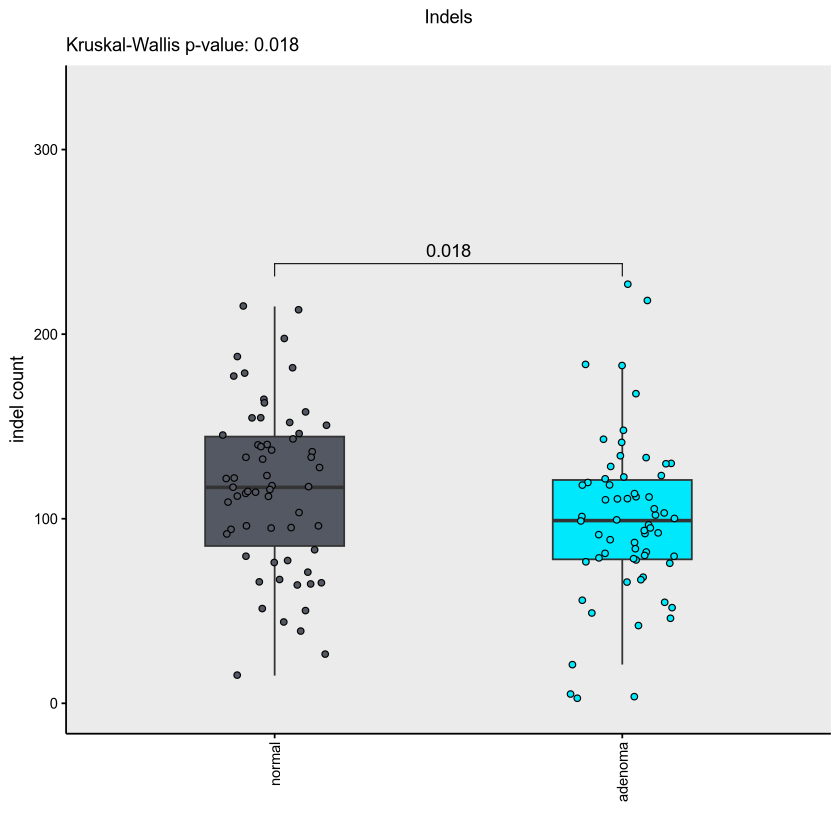

In [75]:
F2b_boxplot_indels

In [76]:
F2d_indel_profile = plot_indel_contexts2(id_mm) +
    theme_minimal_hgrid() +
    scale_y_continuous(n.breaks = 3) +
    theme(panel.spacing.x = unit(0, "mm"),
          legend.position = "none",
          axis.text.x = element_text(size = 5),
          strip.text.y = element_text(size = 9),
          axis.text.y = element_text(size = 8))

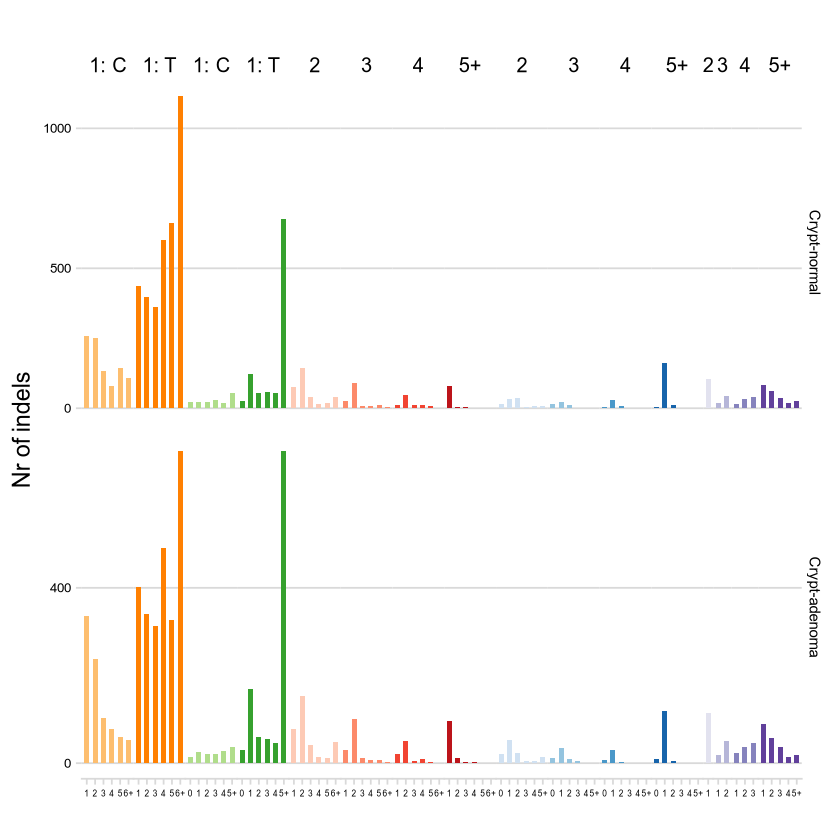

In [77]:
F2d_indel_profile

In [78]:
cos_sim(id_mm[,"normal"], id_mm[, "adenoma"])

ERROR: Error in id_mm[, "normal"]: subscript out of bounds


In [ ]:
signatures = read_delim("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/COSMIC_v3.5_SBS_GRCh38.txt") %>%
  arrange(match(Type, TRIPLETS_96))
artefact_signatures = c("SBS27", "SBS43","SBS45","SBS46", "SBS47","SBS48","SBS49","SBS50","SBS51","SBS52",'SBS53',"SBS54",'SBS55','SBS56','SBS57','SBS58','SBS59','SBS60')
sigs = signatures[,!colnames(signatures) %in% artefact_signatures] # remove signatures marked as artefacts
id_signatures = read_delim("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/COSMIC_v3.4_ID_GRCh37.txt")

In [ ]:
sigs_known = signatures[, c("SBS1", "SBS5", "SBS18", "SBS88")]

In [ ]:
fit_res = fit_to_signatures(mut_mat, as.matrix(sigs_known))

In [ ]:
fit_res_clones_sbs = fit_res$contribution %>%
    prop.table(2) %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "SBS88")
  fit_res_clones_sbs = merge(fit_res_clones_sbs, categories)

In [ ]:
ktest_refit = kruskal.test(value ~ injection, data = fit_res_clones_sbs)
  subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest_refit$p.value, 3))


  F2g_sbs_refit = ggplot(fit_res_clones_sbs, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.shape = NA, width = 0.5) +
    geom_jitter(shape = 21, width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), method = "dunn_test", p.adjust.method =  "fdr", label = "{p.adj.format}") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(fit_res_clones_sbs$value)*1.45)) +
    labs( y = "Relative SBS88 contribution", x ="", subtitle = subtitle) +
    theme(legend.position =  "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  F2g_sbs_refit

In [ ]:
id_sigs_select = id_signatures[, c("ID1", "ID2", "ID18")]
  fit_res_id = fit_to_signatures(indel_counts, as.matrix(id_sigs_select))
  fit_res_clones = fit_res_id$contribution %>%
    prop.table(2) %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "ID18")
  fit_res_clones = merge(fit_res_clones, categories)

In [ ]:
ktest_refit = kruskal.test(value ~ injection, data = fit_res_clones)
subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest_refit$p.value, 3))

In [ ]:
Fig2h_indel_refit = ggplot(fit_res_clones, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.size = 0, width = 0.5) +
    geom_jitter(shape = 21, width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), method = "dunn_test", p.adjust.method =  "fdr", label = "p.adj.format") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(fit_res_clones$value)*1.30)) +
    labs(subtitle = subtitle, y = "Relative ID18 contribution", x = "") +
    theme(legend.position =  "none", axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


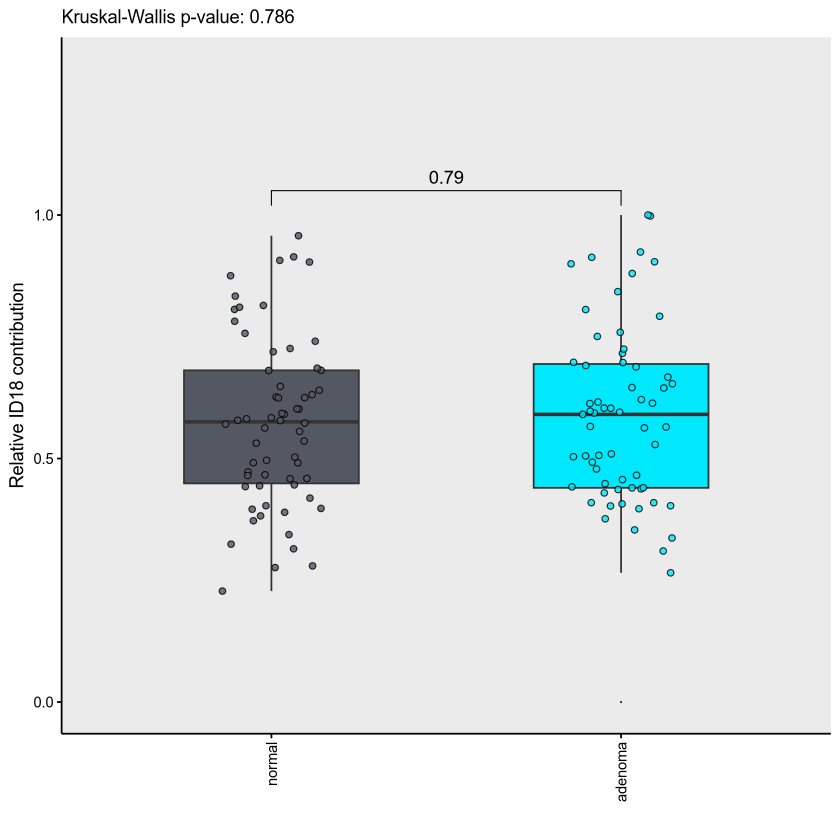

In [79]:
Fig2h_indel_refit

In [ ]:
figure_2 = F2a_sbs_boxplot + F2b_boxplot_indels + F2c_sbs_profile + F2d_indel_profile + F2g_sbs_refit + Fig2h_indel_refit + plot_layout(guides = "collect", byrow = F, nrow = 2,widths = c(1,1.5,1)) + plot_annotation(tag_levels = "A")



In [ ]:
# Rebuttal figure 2: Mutational loads for signatures in absolute counts
fit_res_clones = fit_res_id$contribution %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "ID18")

fit_res_clones = merge(fit_res_clones, categories)

rebuttal_2_indel_refit = ggplot(fit_res_clones, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.size = 0, width = 0.15, alpha = 0.6) +
    geom_jitter(width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), ref.group	= "Control", p.adjust.method =  "fdr", label = "p.adj") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    ylab("Absolute ID18 contribution") + xlab("") +
    theme(legend.position =  "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle("Indels")

fit_res_clones_sbs = fit_res$contribution %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "SBS88")

fit_res_clones_sbs = merge(fit_res_clones_sbs, categories)


In [ ]:
rebuttal_2_indel_refit

In [ ]:
rebuttal_2_sbs_refit = ggplot(fit_res_clones_sbs, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.shape = NA, width = 0.15, alpha = 0.6) +
    geom_jitter(width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), ref.group	= "Control", p.adjust.method =  "fdr", label = "p.adj") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    ylab("Absolute SBS88 contribution") + xlab("") +
    theme(legend.position =  "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle("singe base substitutions")

Warning message:
“Computation failed in `stat_pwc()`.
Caused by error in `if (ref.group != "") ...`:
! missing value where TRUE/FALSE needed”
Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


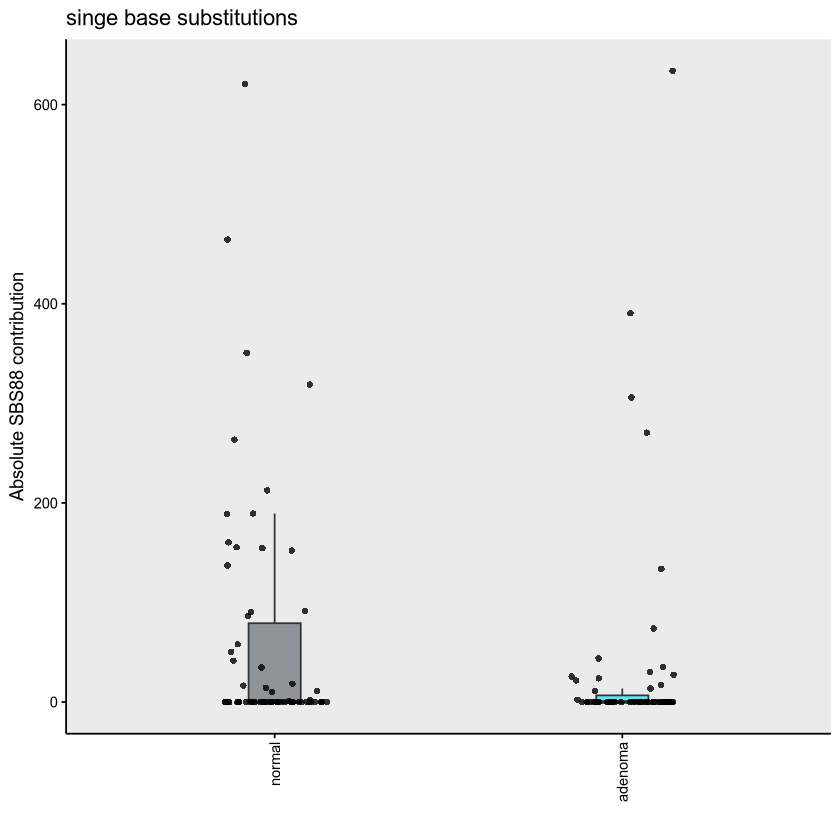

In [80]:
rebuttal_2_sbs_refit

In [ ]:
left = ggarrange(F2a_sbs_boxplot, F2b_boxplot_indels, labels = c("B", "C"), nrow = 2)
middle = ggarrange(F2c_sbs_profile, F2d_indel_profile, labels = c("D", "E"),  nrow = 2)
right = ggarrange(F2g_sbs_refit, Fig2h_indel_refit, labels = c("F", "G"), nrow = 2)
figure_1 =  ggarrange(left, middle, right, widths = c(1,  2, 1), ncol = 3)

plot_list = list(F2a_sbs_boxplot = F2a_sbs_boxplot,
                   F2b_boxplot_indels = F2b_boxplot_indels,
                   F2c_sbs_profile = F2c_sbs_profile,
                   F2d_indel_profile = F2d_indel_profile,
                   F2g_sbs_refit = F2g_sbs_refit,
                   Fig2h_indel_refit = Fig2h_indel_refit)

In [ ]:
plot_list

In [ ]:
mm = t(mut_mat) %>% data.table(keep.rownames = "name")
mm = merge(categories, mm, by = "name")

In [ ]:
mm_cat = mm %>% group_by(injection, method) %>%
  dplyr::select(-name) %>%
  summarize_all(sum) %>%
  mutate(name = paste0(method, "-", injection)) %>%
  mutate(name = gsub("Clonal Expansion-", "CE", name)) %>%
  ungroup() %>%
  dplyr::select(-method, -injection) %>%
  column_to_rownames("name") %>%
  as.matrix() %>%
  t()

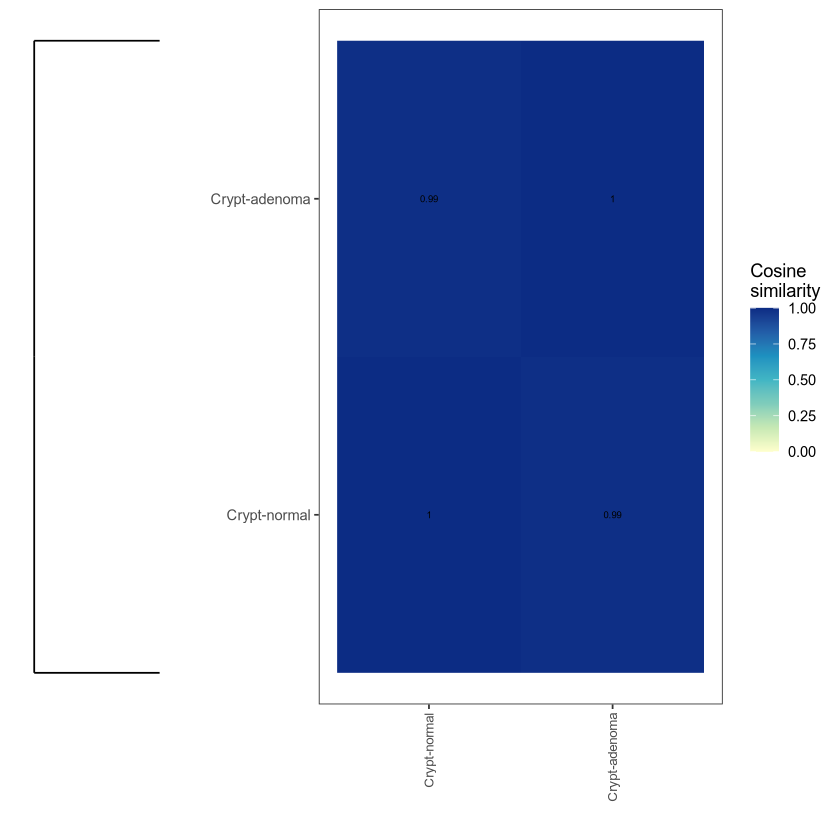

In [81]:
cossim_all = cos_sim_matrix(mm_cat, mm_cat)
cos_mat_sbs = plot_cosine_heatmap2(cossim_all, cluster_cols = TRUE, plot_values = TRUE)
cos_mat_sbs


In [82]:
# Indel cosine similarities:
id_mm = t(indel_counts) %>% data.table(keep.rownames = "name")
id_mm = merge(id_mm, categories) %>% group_by(injection, method) %>%
  dplyr::select(-name) %>%
  summarize_all(sum) %>%
  mutate(name = paste0(method, "-", injection)) %>%
  mutate(name = gsub("Clonal Expansion-", "CE", name)) %>%
  ungroup() %>%
  dplyr::select(-method, -injection) %>%
  column_to_rownames("name") %>%
  as.matrix() %>%
  t()

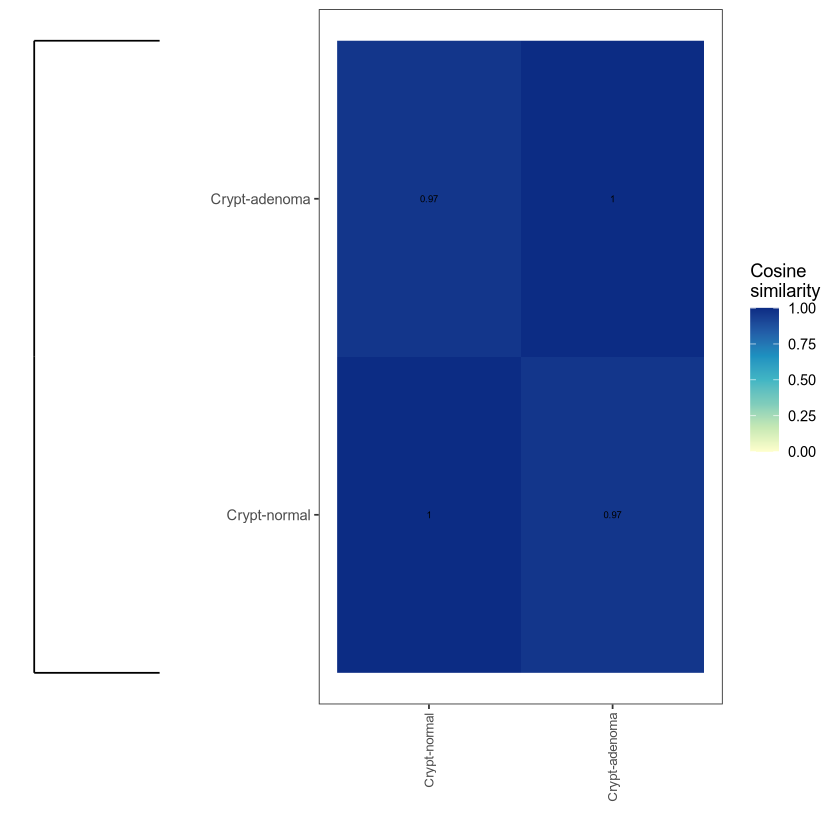

In [83]:
cosine_indel_all = cos_sim_matrix(id_mm, id_mm)
cos_mat_indel = plot_cosine_heatmap2(cosine_indel_all, cluster_cols = TRUE, plot_values = TRUE) +
  guides(fill = "")
cos_mat_indel


Above here is Figure 1. Wahoo

In [128]:
save.image(file = "colibactinFig1.RData")